## 3.3 How does the players' clicking behavior compare itself to PageRank ? Are players significantly more biased than a random walk on the graph ?
In the previous part, we saw that the click counts of the players can be partly explained by the structure of the graph. But how much does the graph influence the players ? If we could completely remove the bias from the graph, would we still see a bias in the way players choose their paths ? To answer this question, we will compare the players' clicking behavior with a random walk on the graph, and see whether the players are "more biased" than a random walker.

In [1]:
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chisquare

from src.data.some_dataloader import *
from articles_clicks_links import click_count_in_paths
from functions import pagerank
from plots import top_player_vs_pagerank_article_frequencies, top_player_vs_pagerank_country_frequencies

### Running PageRank
First, let us the PageRank algorithm on the Wikipedia graph. We use a helper function for this that takes as input the edges from the Wikipedia graph, that is the links dataframe.

In [2]:
links_df = load_links_dataframe()
df_pagerank = pagerank(links_df)
df_pagerank

,article_name,rank
0,United_States,0.009566
1,France,0.006423
2,Europe,0.006340
3,United_Kingdom,0.006235
4,English_language,0.004865
...,...,...
4587,Grange_Hill,0.000033
4588,Grand_Central_Station_%28Chicago%29,0.000033
4589,Gowanus_Canal,0.000033
4590,Gordon_Griffith,0.000033


### Computing players rank based on their click counts
Next, we will compute a rank similar to that of PageRank, but based on the click counts of the players. For each article $a$, we define its rank as:
$$r_a = \frac{c_a}{\sum_{a' \in A}{c_{a'}}}$$
where
* $c_a$ is the click count of the article $a$ (the number of times it appears in the recorded player paths)
* $A$ is the set of all articles in the Wikipedia graph
With this definition we have that $ 0 \le r_a \le 1 \hspace{2mm} \forall a$ and $\sum_{a \in A}{r_a} = 1$ which are the properties necessary to compare our ranks with PageRank.

A few notes:
* Here we want our rank $r_a$ to describe as closely as possible the decisions of the players, so that we can compare it to PageRank which will be considered the baseline (a random walker makes no decisions at all). However we need to be careful: as shown in 3.1, the distribution of start / target articles in the paths is heavily biased towards USA and UK, due to the biased distribution of articles in the graph. Thus, when computing the click counts for articles, we need to not take into account those articles, since they do not truly represent the players decisions (the start / target articles are not chosen by the players!). So we remove the start and target articles (first and last articles for finished paths, and first articles for unfinished paths) before computing click counts.
* There is a special article in the graph called `Wikipedia_Text_of_the_GNU_Free_Documentation_License`. During the analysis, it was found that it has a relatively high click_count (~150), although in the graph it has in-degree and out-degree of 0 (thus a PageRank of 0). Upon closer observation, we saw that it was actually linked in all Wikipedia articles, at the bottom, as part of the license. Thus, during games, players could reach it from any article, and this was recorded in the players paths. However, in the graph data given to us, this article is considered to have in-degree 0 (which makes sense, otherwise we would have an article with an enormous in-degree, given that it is linked in all Wikipedia articles). Thus for better analysis, we decided to discard that article as its rank $r_a$ was much higher than the PageRank of 0.

In [3]:
articles = load_articles_dataframe()
finished_paths = load_path_finished_dataframe()
unfinished_paths = load_path_unfinished_distance_dataframe()
paths_merged = pd.concat([finished_paths["path"].apply(lambda row: row.split(';')[1:-1]), unfinished_paths["path"].apply(lambda row: row.split(';')[1:])])
# Remove start / target articles (see notes above)
df_clicks = click_count_in_paths(articles, paths_merged)
df_clicks = df_clicks[df_clicks.index != 'Wikipedia_Text_of_the_GNU_Free_Documentation_License'] # Remove GNU license article (see notes above)
df_player_frequencies = df_clicks.copy()
df_player_frequencies.click_count = df_player_frequencies.click_count / df_player_frequencies.click_count.sum()
df_player_frequencies.rename(columns={'click_count': 'rank'}, inplace=True)
df_player_frequencies.index.name = 'article_name'
df_player_frequencies.reset_index(inplace=True)
df_player_frequencies.sort_values(by='rank', ascending=False, inplace=True, ignore_index=True)
df_player_frequencies

there are 348573 clicks in the whole whikispeedia dataset (both finished and unfinished paths)


,article_name,rank
0,United_States,0.039272
1,Europe,0.017629
2,United_Kingdom,0.016756
3,England,0.013664
4,Earth,0.013124
...,...,...
4598,Canaletto,0.000000
4599,Nathu_La,0.000000
4600,Cape_Porcupine,0.000000
4601,Nanomedicine,0.000000


Let us first plot a raw comparison of the top 40 PageRank articles and the associated players rank

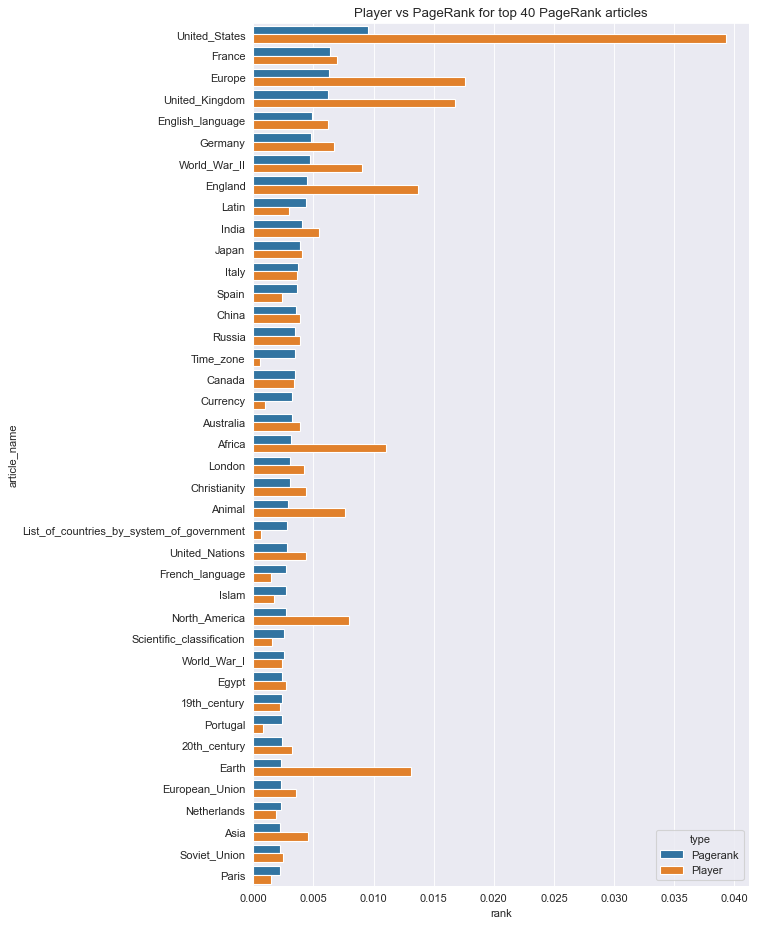

In [4]:
top_player_vs_pagerank_article_frequencies(df_player_frequencies, df_pagerank)

We see that for a lot of articles from Western cultures like `United_States`, `Europe` or `England`, the players rank is higher! However, articles like `Africa` also have a higher player rank. Given that players usually try to reach hubs in their paths to the target article, it is to be expected that general articles like `Africa` still get a higher rank: they are considered by players like "general knowledge hubs" and are often targeted by players. This is an issue: some articles will have a very high rank just because they are considered hubs by players. To make an analysis that is not too sensitive on such articles, we will go coarser grain: we will aggregate articles by country, and compute a rank for each country. the rank for a country $c$ is simply:
$$r_c = \sum_{a \in A_c} r_a$$
where
* $A_c$ is the set of all articles linked to the country $c$

To do that, we associate each article with its country.

In [5]:
article_to_countries = pd.read_csv('data/country_occurences.csv', index_col=0)[['Top_1_name']]
article_to_countries.rename(columns={'Top_1_name': 'country_name'}, inplace=True)
article_to_countries.index.name = 'article_name'
article_to_countries.reset_index(inplace=True)

df_player_frequencies = pd.merge(df_player_frequencies, article_to_countries, on='article_name')
df_pagerank = pd.merge(df_pagerank, article_to_countries, on='article_name')

Now that each article is associated to a country, we can draw the same graph, but comparing country aggregates instead of individual articles.

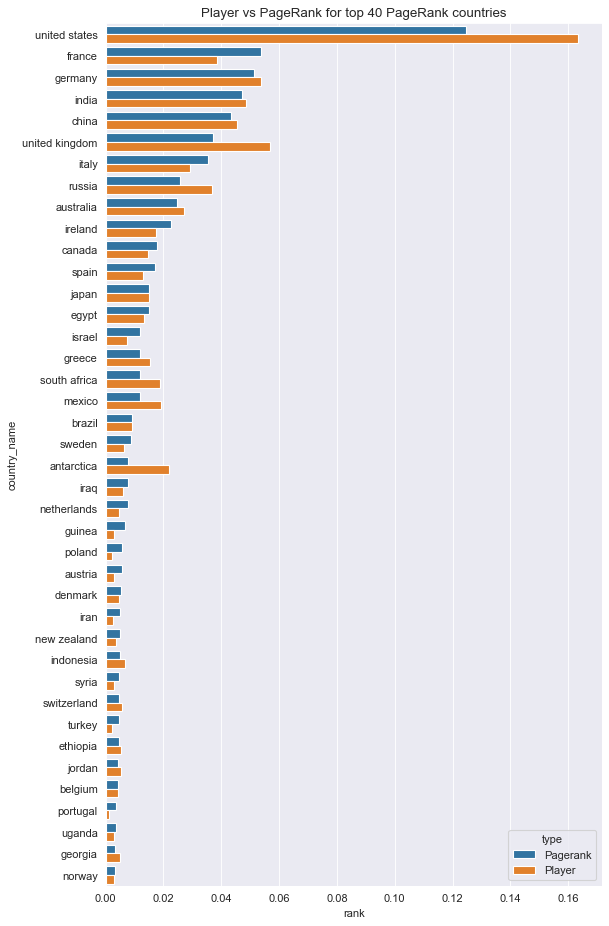

In [6]:
top_player_vs_pagerank_country_frequencies(df_player_frequencies, df_pagerank)

The differences are smaller when we aggregate per country, but again, we still see a bias towards western countries (mostly english speaking countries, actually!).

### Computing rank difference
To investigate further, we will compute the difference between the players rank and the pageranks. Here the difference $d_a$ is defined as:
$$ d_a = r_a - \mathtt{PageRank}_a $$
That way, when it is positive, it means the players tend to go more often to article $a$ than random walk, whereas when it is negative, it means players tend to go less often to article $a$ than random walk.

In [7]:
rank_v_freq_2_columns = pd.merge(df_pagerank[['article_name', 'rank']], df_player_frequencies[['article_name', 'country_name', 'rank']], on='article_name', suffixes=('_pagerank', '_players'), how='right')
rank_v_freq_2_columns = rank_v_freq_2_columns.fillna({'rank_pagerank': 0}) # fill missing pagerank values (those where isolated articles that were not added to the graph, they all have click_count 0 anyway and the pagerank should be 0 too)
rank_v_freq_2_columns['rank_diff'] = rank_v_freq_2_columns['rank_players'] - rank_v_freq_2_columns['rank_pagerank']
rank_v_freq_2_columns.sort_values(by='rank_pagerank', inplace=True, ignore_index=True, ascending=False)
rank_v_freq_2_columns

,article_name,rank_pagerank,country_name,rank_players,rank_diff
0,United_States,0.009566,united states,0.039272,0.029706
1,France,0.006423,france,0.006988,0.000565
2,Europe,0.006340,russia,0.017629,0.011290
3,United_Kingdom,0.006235,united kingdom,0.016756,0.010522
4,English_language,0.004865,united states,0.006210,0.001345
...,...,...,...,...,...
4598,Private_Peaceful,0.000000,NaN,0.000000,0.000000
4599,Lone_Wolf_%28gamebooks%29,0.000000,united states,0.000000,0.000000
4600,Suikinkutsu,0.000000,japan,0.000000,0.000000
4601,Underground_%28stories%29,0.000000,japan,0.000000,0.000000


Again, we aggregate by country.

In [8]:
rank_v_freq_countries = rank_v_freq_2_columns.drop(columns=['article_name']).groupby('country_name', as_index=False, dropna=False).sum()
rank_v_freq_countries.sort_values(by='rank_pagerank', inplace=True, ignore_index=True, ascending=False)
rank_v_freq_countries

,country_name,rank_pagerank,rank_players,rank_diff
0,NaN,0.155270,0.189435,0.034165
1,united states,0.124624,0.163399,0.038774
2,france,0.053814,0.038494,-0.015320
3,germany,0.051304,0.053739,0.002435
4,india,0.047088,0.048482,0.001394
...,...,...,...,...
208,niue,0.000114,0.000000,-0.000114
209,pitcairn islands,0.000102,0.000013,-0.000089
210,norfolk island,0.000096,0.000013,-0.000084
211,st. martin,0.000064,0.000010,-0.000055


Let us see how the difference looks like further in the articles list. To do that, we plot the PageRanks and players ranks for all articles, sorted by PageRank. For comparison, we do the same with country aggregates.

Note: here `NaN` represents articles with no linked countries. We see that they make up for about 15% of the PageRank! However those articles are discarded in our analysis since we concentrate on Western cultural biases.

<Axes: title={'center': 'Player rank vs PageRank by countries'}, xlabel='country_name'>

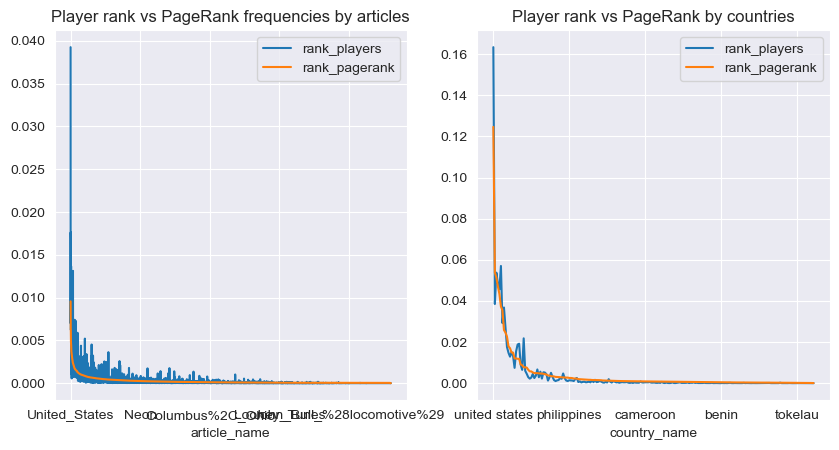

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(10)
ax1.set_title('Player rank vs PageRank frequencies by articles')
rank_v_freq_2_columns.plot(x='article_name', y='rank_players', ax=ax1)
rank_v_freq_2_columns.plot(x='article_name', y='rank_pagerank', ax=ax1)

ax2.set_title('Player rank vs PageRank by countries')
rank_v_freq_countries.dropna().plot(x='country_name', y='rank_players', ax=ax2)
rank_v_freq_countries.dropna().plot(x='country_name', y='rank_pagerank', ax=ax2)

Here we can very clearly see the impact of aggregating by country: it reduces the variance of the difference by summing over all articles from a given country. We will thus focus on analyzing the difference on a country basis as it is a more stable metric. Also, obviously, since we want to detect bias towards certain countries, it makes more sense to aggregate by country.

### High difference countries
Now we will have a look at which countries have the highest difference with respect to PageRank. To do this we sort the differences aggregated by countries from higher to lower values, and then analyze the countries with the highest positive difference (players tend to go more often to them than random walk), and highest negative difference (players tend to go less often to them than random walk)

In [10]:
rank_v_freq_by_diff = rank_v_freq_countries.dropna().sort_values(by='rank_diff', ascending=False)
rank_v_freq_by_diff

,country_name,rank_pagerank,rank_players,rank_diff
1,united states,0.124624,0.163399,0.038774
6,united kingdom,0.037278,0.057000,0.019722
21,antarctica,0.007732,0.021801,0.014069
8,russia,0.025858,0.036805,0.010947
18,mexico,0.011825,0.019179,0.007354
...,...,...,...,...
12,spain,0.016984,0.012893,-0.004091
15,israel,0.012014,0.007448,-0.004566
10,ireland,0.022564,0.017547,-0.005017
7,italy,0.035398,0.029221,-0.006178


<Axes: xlabel='rank_diff', ylabel='country_name'>

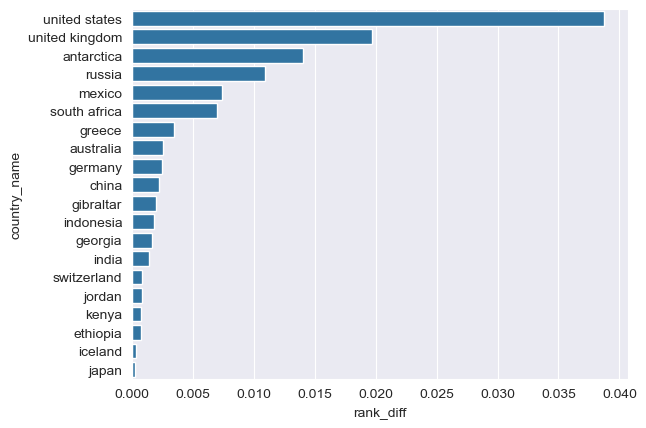

In [11]:
sns.barplot(rank_v_freq_by_diff.head(20), y='country_name', x='rank_diff', orient='y')

<Axes: xlabel='rank_diff', ylabel='country_name'>

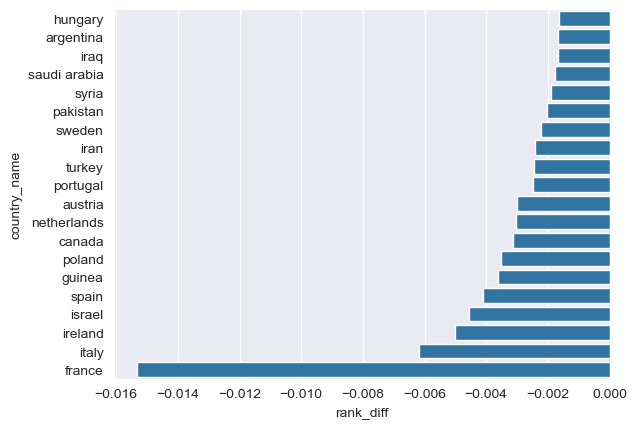

In [12]:
sns.barplot(rank_v_freq_by_diff.tail(20), y='country_name', x='rank_diff', orient='y')

These results seem to indicate a bias towards english speaking countries: USA and UK have the highest positive difference. Note that this is different from a bias towards Western countries! As we can see, a lot of Western countries have high negative difference, meaning players travel less often to them than random walk (France for example).

### Statistical significance
Lastly, to make sure our conclusions are valid, let us see if the difference in the players behavior is statistically significant. To do that, we compute a chi-square test with the null hypothesis that players rank and PageRank come from the same multinomial distribution. The number of trials (parameter $n$ of the distribution) is set to the total number of clicks in the game.

In [13]:
# p-value for significance of divergence in distribution
total_number_of_clicks = df_clicks['click_count'].sum()
chisquare(rank_v_freq_countries['rank_players'] * total_number_of_clicks, rank_v_freq_countries['rank_pagerank'] * total_number_of_clicks)

Power_divergenceResult(statistic=48887.85720332593, pvalue=0.0)

Given that the p-value is very close to 0 (floating point has approximated it to 0), we can conclude that the players behave significantly differently than a random walk. Although they are not particularly biased towards all Western countries, they seem to be biased toward english speaking countries.